### An Implementation Of Batch Gradient Descent With $L_2$ Regularization And Early Stopping For Softmax Regression Without Using Scikit-learn

In [75]:
import numpy as np
np.random.seed(2041)

from sklearn import datasets
iris = datasets.load_iris()

In [76]:
def my_test_split(X, y, test_ratio = 0.2, validation_ratio = 0.2):
    total_size = len(X)
    test_size = int(total_size * test_ratio)
    valid_size = int(total_size * validation_ratio)
    train_size = total_size - test_size - valid_size
    
    permutation_indices = np.random.permutation(total_size)
    
    X_train = X[permutation_indices[:train_size]]
    y_train = y[permutation_indices[:train_size]]
    X_valid = X[permutation_indices[train_size:-test_size]]
    y_valid = y[permutation_indices[train_size:-test_size]]
    X_test = X[permutation_indices[-test_size:]]
    y_test = y[permutation_indices[-test_size:]]
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [77]:
def encode_output(y_output, possible_outputs):
    m = len(y_output)
    encoding = np.zeros((m, possible_outputs))
    encoding[np.arange(m), y_output] = 1
    return encoding

In [78]:
X = iris["data"][:, (2,3)]
y = iris["target"]

X_with_bias = np.c_[np.ones([len(X), 1]), X]

X_train, y_train, X_valid, y_valid, X_test, y_test = my_test_split(X_with_bias, y)

y_train_one_hot = encode_output(y_train, len(np.unique(y)))
y_valid_one_hot = encode_output(y_valid, len(np.unique(y)))
y_test_one_hot = encode_output(y_test, len(np.unique(y)))

In [79]:
def softmax(logits):
    exps = np.exp(logits)
    exps_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exps_sums

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

In [80]:
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y))
m = len(X_train)
epsilon = 1e-7
iterations = 5001
eta = 0.01

theta = np.random.rand(n_inputs, n_outputs)
for i in range(iterations):
    logits = X_train.dot(theta)
    y_proba = softmax(logits)
    loss = -np.mean(np.sum(np.log(y_proba + epsilon) * y_train_one_hot, axis = 1))
    
    if i % 500 == 0:
        print(f"iteration: {i}, loss: {loss}")
    
    error = y_proba - y_train_one_hot

    gradients = 1/m * (X_train.T.dot(error))
    theta = theta - eta * gradients

iteration: 0, loss: 1.3616236424737729
iteration: 500, loss: 0.712267812065665
iteration: 1000, loss: 0.6146619861022742
iteration: 1500, loss: 0.5523659768747184
iteration: 2000, loss: 0.5086729950532366
iteration: 2500, loss: 0.4758470725246894
iteration: 3000, loss: 0.4499263609434202
iteration: 3500, loss: 0.4286927896259171
iteration: 4000, loss: 0.41080997609902103
iteration: 4500, loss: 0.3954232055412157
iteration: 5000, loss: 0.38195849619255023


In [81]:
theta

array([[ 3.89895791, -0.10263181, -2.18024152],
       [-0.15000429,  1.08765302,  0.7134073 ],
       [-0.77633764,  0.26158409,  2.69523966]])

In [82]:
logits = X_valid.dot(theta)
y_proba = softmax(logits)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9

### With Regularization

In [83]:
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y))
m = len(X_train)
epsilon = 1e-7
iterations = 5001
eta = 0.1
alpha = 0.1

r_theta = np.random.rand(n_inputs, n_outputs)
for i in range(iterations):
    logits = X_train.dot(r_theta)
    y_proba = softmax(logits)
    entropy_loss = -np.mean(np.sum(np.log(y_proba + epsilon) * y_train_one_hot, axis = 1))
    l2_loss = 0.5 * np.sum(np.square(theta[1:]))
    loss = entropy_loss + l2_loss
    
    if i % 500 == 0:
        print(f"iteration: {i}, loss: {loss}")
    
    error = y_proba - y_train_one_hot
    gradients = 1/m * (X_train.T.dot(error)) + np.r_[np.zeros([1, n_outputs]), alpha * r_theta[1:]]
    r_theta = r_theta - eta * gradients

iteration: 0, loss: 6.060682648084744
iteration: 500, loss: 5.2874504015496795
iteration: 1000, loss: 5.236207922664984
iteration: 1500, loss: 5.2144927933445535
iteration: 2000, loss: 5.202864248790928
iteration: 2500, loss: 5.196026382700796
iteration: 3000, loss: 5.1918137447384725
iteration: 3500, loss: 5.189149651353789
iteration: 4000, loss: 5.187438057513057
iteration: 4500, loss: 5.186327456179428
iteration: 5000, loss: 5.185602220184826


In [84]:
logits = X_valid.dot(r_theta)
y_proba = softmax(logits)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

### With Early Stopping

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

In [85]:
n_iterations = 5001
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y))
e_theta = np.random.rand(n_inputs, n_outputs)
m = X_train.shape[0]
eta = 0.1
alpha = 0.1
best_loss = np.infty

for i in range(n_iterations):
    logits = X_train.dot(e_theta)
    proba = softmax(logits)
    
    label_proba = np.sum(proba * y_train_one_hot, axis=1)
    adjusted_label_proba = label_proba + epsilon
    log_label_proba = np.log(adjusted_label_proba)
    entropy_loss = -np.mean(log_label_proba)
    l2_loss = np.sum(np.square(e_theta[1:])) / 2
    loss = entropy_loss + alpha * l2_loss
    # loss = np.sum(-np.log(np.sum(proba * y_train_one_hot, axis=1) + epsilon))
    
    gradient_matrix = X_train.T.dot(proba - y_train_one_hot) / m + alpha * np.r_[np.zeros([1, n_outputs]), e_theta[1:]]
    e_theta -= eta * gradient_matrix
    logits = X_train.dot(e_theta)
    proba = softmax(logits)
    label_proba = np.sum(proba * y_train_one_hot, axis=1)
    adjusted_label_proba = label_proba + epsilon
    log_label_proba = np.log(adjusted_label_proba)
    entropy_loss = -np.mean(log_label_proba)
    l2_loss = np.sum(np.square(e_theta[1:])) / 2
    loss = entropy_loss + alpha * l2_loss
    
    if i % 500 == 0:
        print(f"iteration {i}, loss: {loss}")
    
    if loss < best_loss:
        best_loss = loss
    else:
        print(i-1, best_loss, "best loss")
        print(i, loss, "early stopping")
        break

iteration 0, loss: 1.325649383035112
iteration 500, loss: 0.539513925344459
iteration 1000, loss: 0.5106583017596114
iteration 1500, loss: 0.5023967459616581
iteration 2000, loss: 0.4994042196999483
iteration 2500, loss: 0.4982267334414495
iteration 3000, loss: 0.4977438117050731
iteration 3500, loss: 0.4975410245643562
iteration 4000, loss: 0.4974546487524043
iteration 4500, loss: 0.4974175285571618
iteration 5000, loss: 0.4974014852631339


In [86]:
logits = X_valid.dot(e_theta)
proba = softmax(logits)
y_valid_predict = np.argmax(proba, axis = 1)

accuracy_score = np.mean(y_valid == y_valid_predict)
accuracy_score

0.9666666666666667

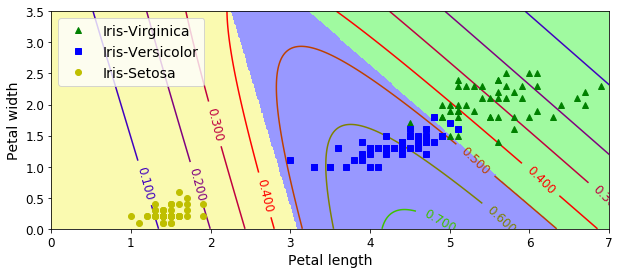

In [87]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

x0, x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1),
    np.linspace(0, 3.5, 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(e_theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis = 1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

plt.show()

In [88]:
logits = X_test.dot(e_theta)
proba = softmax(logits)
y_predict = np.argmax(proba, axis=1)

accuracy_score = np.sum(y_predict == y_test) / len(y_test)
accuracy_score

1.0